##### **Exploratory Data Analysis and other Mandatory preprcessing were performed on local machine (Notebook Exploratory Data Analysis.ipynb)**

- Original Dataset Directory has following structure
    - CelebA-HQ-img
        - 300000 celeb images
    - CelebA-HQ-to-CelebA-mapping.txt
    - CelebAMask-HQ-attribute-anno.txt
    - CelebAMask-HQ-mask-anno
        - 15 Subdirectories(0-14) each contains masks for           2000 images  
    - CelebAMask-HQ-pose-anno.txt
    - README.txt
 
- I have combined the Lips, Eyes and Mouth mask corresponding to each celeb img and organized them into a directory in following manner:

  - CelebA-HQ-img
    - 300000 celeb images
  - Masks
    - 300000 Masks
    
- Now We're ready to train our model

# **Eyes and Lips Segmentation**

## 0. Dependencies

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
import os
import shutil
from pathlib import Path

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
import cv2

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import Adam

In [0]:
from tqdm import tqdm_notebook

## 1. Data Collection and Pipeline
I have uploaded the preprocess dataset on gdrive and now I have to mount the drive in order to get the data here in this notebook

In [0]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
## data in the drive is compressed now I need to unzip it
# !unzip /content/drive/My\ Drive/CelebA-HQ-img
# !unzip /content/drive/My\ Drive/merged-mask

In [0]:
img_path = 'CelebA-HQ-img/'
mask_path = 'merged-mask/'

In [0]:
# 
img_list = os.listdir('CelebA-HQ-img/')
mask_list = os.listdir('merged-mask/')

In [0]:
print(len(img_list), len(mask_list))

30000 29995


In [0]:
# It seems for each img we don't have a mask and may be vice-versa, 
# lets find out such instances and remove them

# name of the img and corresponding mask is same in the respective directory
for img in img_list:
  if img not in mask_list:
    os.remove(img_path+img)
for mask in mask_list:
  if mask not in img_list:
    os.remove(mask_path+mask)


In [0]:
# Set some parameters
im_width = 256
im_height = 256
img_list = os.listdir('CelebA-HQ-img/')
mask_list = os.listdir('merged-mask/')

In [0]:
# fair enough
print(len(img_list), len(mask_list))

29995 29995


In [0]:
# check whether img_list and corresponding mask_list is same
if mask_list==img_list:
  print('valid')
else:
  print('invalid')

valid


In [0]:
# read file
def read_img(file, path):
  img = cv2.imread(path+file)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (im_height, im_width))
  return img

In [0]:
# show images in grid
def show_img(imgs, cols=3):
  
  rows = len(imgs)//cols
  
  f, axarr = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 15))
  
  i = 0
  for row in range(rows):
    for col in range(cols):
      axarr[row, col].imshow(imgs[i])
      axarr[row, col].get_xaxis().set_visible(False)
      axarr[row, col].get_yaxis().set_visible(False)
      i+=1
  plt.show()

In [0]:
data = []

for i in range(3):
  file = np.random.choice(img_list)
#   print(file)
  img = read_img(file, path=img_path)
  mask = read_img(file, path=mask_path)
  segmented = cv2.addWeighted(img, 1, mask, 0.9, 0)
  data.append(img)
  data.append(mask)
  data.append(segmented)
  

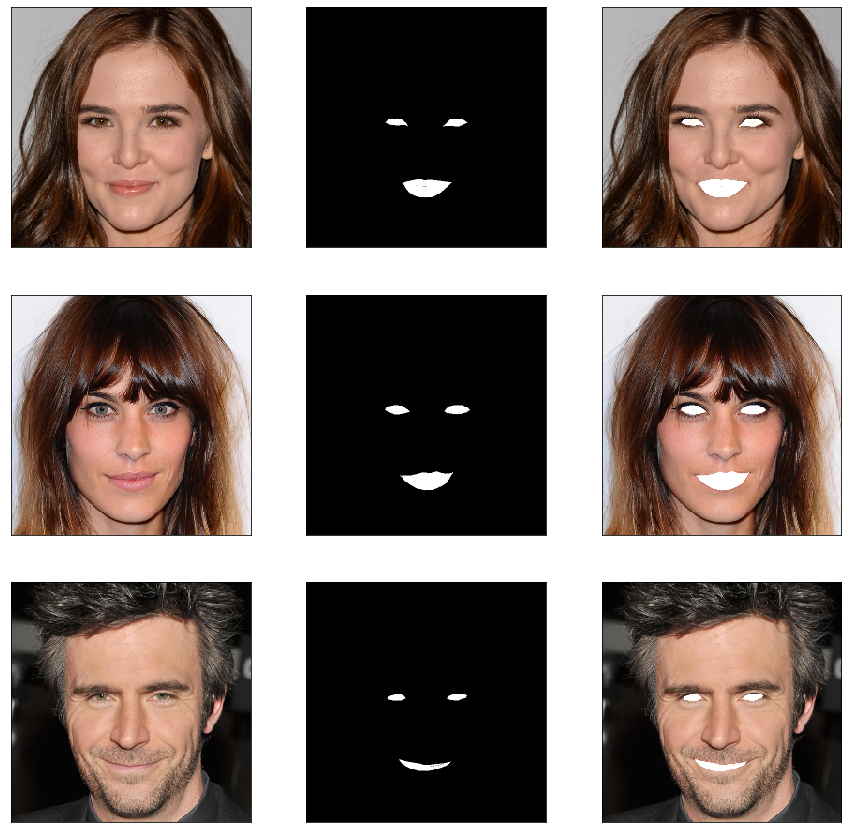

In [0]:
show_img(data)

In [0]:
def read(file, path, mask=False):
  
  '''We will read the both img and mask because the name of file is same in respective directories'''
  img = cv2.imread(path+file)
  img = cv2.resize(img, (im_height, im_width))
  
  if mask:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  
  img = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  
  return img

# Get and resize train images and masks
def data_gen(batch_size=16):
  
    
    
    while True:
      files = np.random.choice(img_list, size=batch_size)
      
      # Although the img_ist and mask_list has same number of input
      x = np.zeros((batch_size, im_height, im_width, 3), dtype=np.float32)
      y = np.zeros((batch_size, im_height, im_width, 1), dtype=np.float32)
      
          
      for i, file in enumerate(files):
      
        # Read img and Mask
        img = read(file, img_path, mask=False)
        mask = read(file, mask_path, mask=True)
        mask = mask.reshape(im_height, im_width, 1)


        # Save images
        x[i] = img
        y[i] = mask
        
      yield (x, y)
        
      

In [0]:
train_gen = data_gen()

## 3. UNet Architecture for Semantic Segmentation

In [0]:
def conv2d_block(input_tensor, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x


In [0]:
def create_unet(input_img, n_filters=16, dropout=0.5, batchnorm=True):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    
    return model

In [0]:
input_img = Input((256, 256, 3), name='img')

model = create_unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 256, 256, 16) 64          conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 16) 0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

In [0]:
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
steps = len(img_list)//16

In [0]:
es = EarlyStopping(patience=2, verbose=1)
mcp = ModelCheckpoint('model.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period = 1)
tb = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

In [128]:
model.fit_generator(train_gen, steps_per_epoch=steps, epochs=2, verbose=1, 
                    callbacks=[es, mcp, tb])



Epoch 1/2
1874/1874 [==============================] - 817s 436ms/step - loss: 0.0086 - acc: 0.9842

Epoch 2/2
1874/1874 [==============================] - 817s 436ms/step - loss: 0.0083 - acc: 0.9843


In [0]:
model.save_weights('u-net_model.h5')

In [0]:
x, y = next(train_gen)

In [0]:
y_pred = model.predict(x)

In [0]:
mask_pred = cv2.cvtColor(y_pred[12], cv2.COLOR_GRAY2RGB)
mask_true = cv2.cvtColor(y[12], cv2.COLOR_GRAY2RGB)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


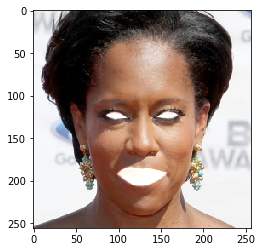

In [123]:
plt.imshow(cv2.addWeighted(x[12], 1, mask_pred, 0.9, 0));

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


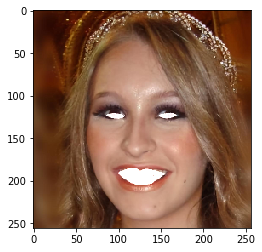

In [124]:
plt.imshow(cv2.addWeighted(x[1], 1, mask_true, 0.9, 0));

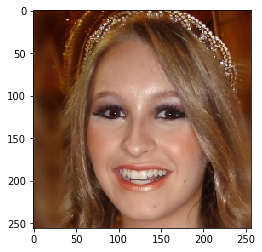

In [117]:
plt.imshow(x[1])